In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import covid
import covid.util as util
import configs

In [73]:
data = util.load_data()

forecast_date='2020-04-04'
config_name = 'strongest_prior'
root='results'
place='PA'
show=True

prefix = f"{root}/{config_name}/{forecast_date}"
config = getattr(configs, config_name)
model_type=config['model']

df = util.score_place(forecast_date,
                      data,
                      place,
                      model_type=config['model'],
                      prefix=prefix)


display(df)

,place,forecast_date,horizon,err,log_score,quantile
date,,,,,,
2020-04-05,PA,2020-04-04,1.0,-4.547668,0.0,0.354
2020-04-06,PA,2020-04-04,2.0,-5.298615,0.0,0.402
2020-04-07,PA,2020-04-04,3.0,30.987015,0.0,0.830
2020-04-08,PA,2020-04-04,4.0,65.320190,-0.19237192,0.890
2020-04-09,PA,2020-04-04,5.0,51.190125,-0.23952703,0.764
2020-04-10,PA,2020-04-04,6.0,76.754333,-0.6539265,0.769
2020-04-11,PA,2020-04-04,7.0,110.364136,-1.1116976,0.761
2020-04-12,PA,2020-04-04,8.0,102.855011,-1.258781,0.715
2020-04-13,PA,2020-04-04,9.0,67.798584,-1.2447948,0.622


  0%|          | 0/51 [00:00<?, ?it/s]

Scoring all places for 2020-04-25 forecast


100%|██████████| 51/51 [00:20<00:00,  2.44it/s]


,horizon,signed_err,MAE,log_score,KS,KS_pval,forecast_date
date,,,,,,,
2020-04-26,1.0,0.641087,19.849837,-0.210037,0.214275,0.015566,2020-04-25
2020-04-27,2.0,-12.415986,25.704700,-0.255223,0.148961,0.188012,2020-04-25
2020-04-28,3.0,-10.097050,28.782676,-0.279611,0.132569,0.305047,2020-04-25
2020-04-29,4.0,1.586428,29.508289,-0.321795,0.126922,0.355747,2020-04-25
2020-04-30,5.0,2.394289,44.458458,-0.404155,0.153020,0.165339,2020-04-25
2020-05-01,6.0,1.270452,51.360129,-0.476148,0.171627,0.087751,2020-04-25
2020-05-02,7.0,-9.760003,59.038881,-0.497030,0.128235,0.343450,2020-04-25
2020-05-03,8.0,-22.382500,61.312990,-0.535409,0.122451,0.399911,2020-04-25
2020-05-04,9.0,-36.864826,68.942144,-0.579519,0.170529,0.091278,2020-04-25


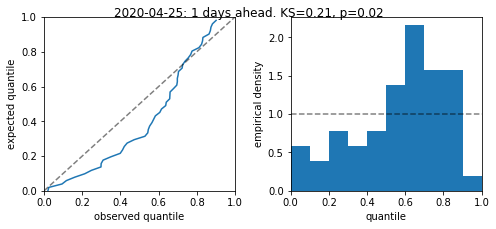

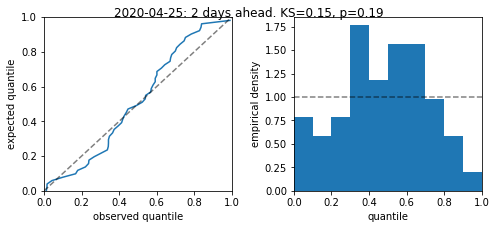

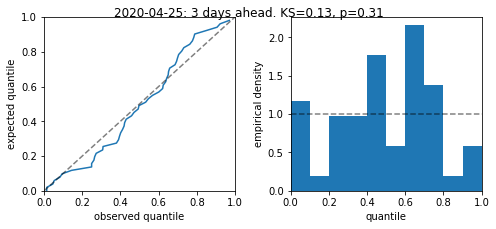

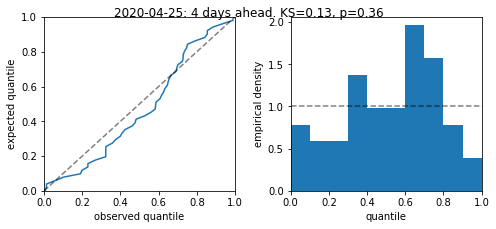

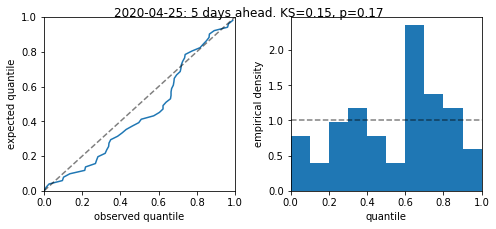

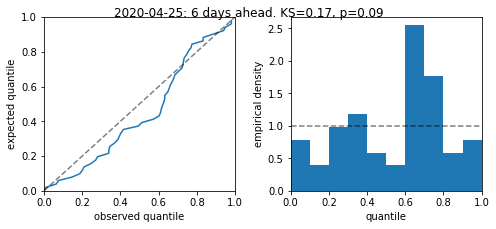

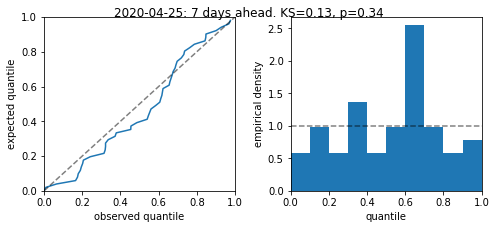

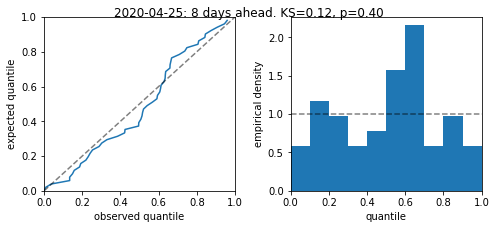

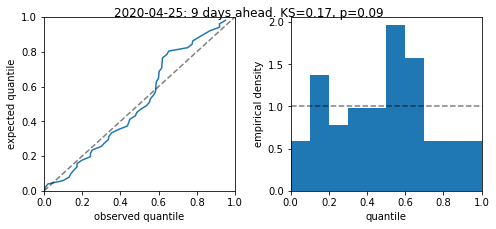

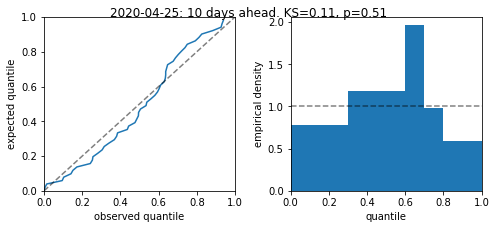

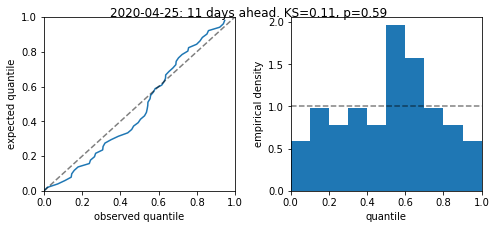

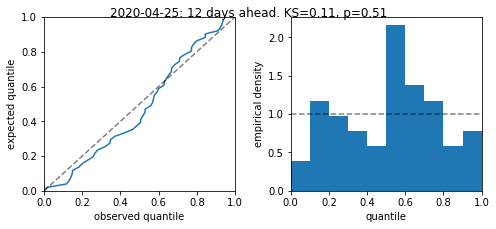

In [80]:
data = util.load_state_data()
root='results'
config_name = 'strongest_prior'
forecast_date = '2020-04-25'

prefix = f"{root}/{config_name}/{forecast_date}"

summary, details = util.score_forecast(forecast_date,
                                       data, 
                                       model_type=covid.models.SEIRD.SEIRD,
                                       prefix=prefix)

display(summary)

qq = False
df = details
for date in df.index.unique():

    fig, axes = plt.subplots(figsize=(7,3.2), ncols=2)
    
    q = np.sort(df.loc[date]['quantile'])
    q_ref = np.arange(len(q))/len(q)
    ks, pval = scipy.stats.kstest(q, 'uniform')

    horizon = int((date-pd.to_datetime(forecast_date))/pd.Timedelta("1d"))

    ax = axes[0]
    ax.plot(q, q_ref)
    ax.plot([0., 1.], [0., 1.], linestyle='--', color='k', alpha=0.5)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('observed quantile')
    ax.set_ylabel('expected quantile')

    ax = axes[1]
    ax.hist(q, bins=10, range=(0., 1.), density=True)
    ax.set_xlim([0, 1])
    ax.plot([0, 1], [1, 1], linestyle='--', color='k', alpha=0.5)
    ax.set_xlabel('quantile')
    ax.set_ylabel('empirical density')
    
    
    plt.suptitle(f"{forecast_date}: {horizon} days ahead. KS={ks:.2f}, p={pval:.2f}")
    
    plt.tight_layout()
    plt.show()

,foo,horizon,MAE,log_score,KS,KS_pval
date,,,,,,
2020-04-19,1,1.0,31.612854,-0.183683,0.090627,0.796321
2020-04-20,1,2.0,36.562292,-0.198416,0.149196,0.186635
2020-04-21,1,3.0,48.710736,-0.273349,0.072294,0.952565
2020-04-22,1,4.0,54.948570,-0.310423,0.100882,0.663613
2020-04-23,1,5.0,62.470313,-0.351894,0.121784,0.406806
2020-04-24,1,6.0,77.232444,-0.414256,0.116314,0.466446
2020-04-25,1,7.0,73.977722,-0.458042,0.113922,0.494239
2020-04-26,1,8.0,91.920086,-0.507871,0.126098,0.363612
2020-04-27,1,9.0,105.630039,-0.552181,0.164706,0.112019
